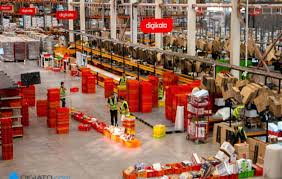

#This project is a deep learning project for detecting watermark on an online shop pictures(Digikala). Digikala is the most famous Iranian website for shopping online.

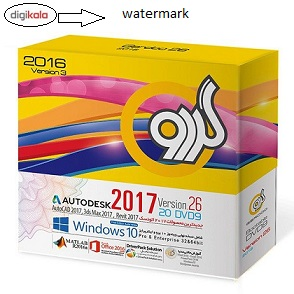

*** 
---
___

In [1]:
import os
import glob
import h5py
import shutil

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg


from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers,optimizers
import cv2
import tensorflow.keras
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.4.0'

In [4]:
data_dir  = 'D:/Dataset/dk-dataset/dataset/'
train_dir = 'D:/Dataset/dk-dataset/dataset/train/'
test_dir = 'D:/Dataset/dk-dataset/dataset/test/'
validation_dir = 'D:/Dataset/dk-dataset/dataset/validation/'

In [5]:
without_watermark_dir = 'D:/Dataset/dk-dataset/dataset/train/negative/'
with_watermark_dir    = 'D:/Dataset/dk-dataset/dataset/train/positive/'

In [6]:
watermark_cases   = glob.glob(with_watermark_dir+'*')
nowatermark_cases = glob.glob(without_watermark_dir+'*')
train_data = []

for img in watermark_cases:
    train_data.append((img,1))
    
for img in nowatermark_cases:
    train_data.append((img,0))
    
train_data = pd.DataFrame(train_data, columns=['image','label'],index=None) 

train_data = train_data.sample(frac=1).reset_index(drop=True)

train_data.head(5)

,image,label
0,D:/Dataset/dk-dataset/dataset/train/positive\S...,1
1,D:/Dataset/dk-dataset/dataset/train/positive\S...,1
2,D:/Dataset/dk-dataset/dataset/train/negative\S...,0
3,D:/Dataset/dk-dataset/dataset/train/negative\S...,0
4,D:/Dataset/dk-dataset/dataset/train/positive\S...,1


In [7]:
cases_count = train_data['label'].value_counts()
print(cases_count)

1    3401
0    3400
Name: label, dtype: int64


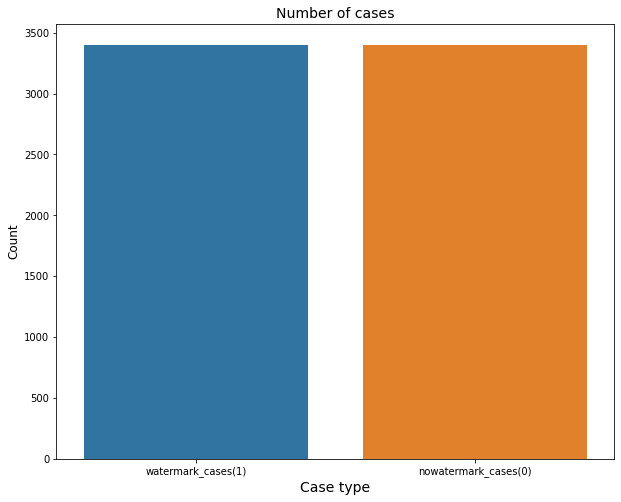

In [8]:
plt.figure(figsize =(10,8))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize = 14)
plt.xlabel('Case type', fontsize =14)
plt.ylabel('Count', fontsize = 12)
plt.xticks(range(len(cases_count.index)), ['watermark_cases(1)','nowatermark_cases(0)'])
plt.show()

*This 2 rows show some pictures of my dataset.The first row shows pictures with watermarks and second row shows pictures without any watermark on them.

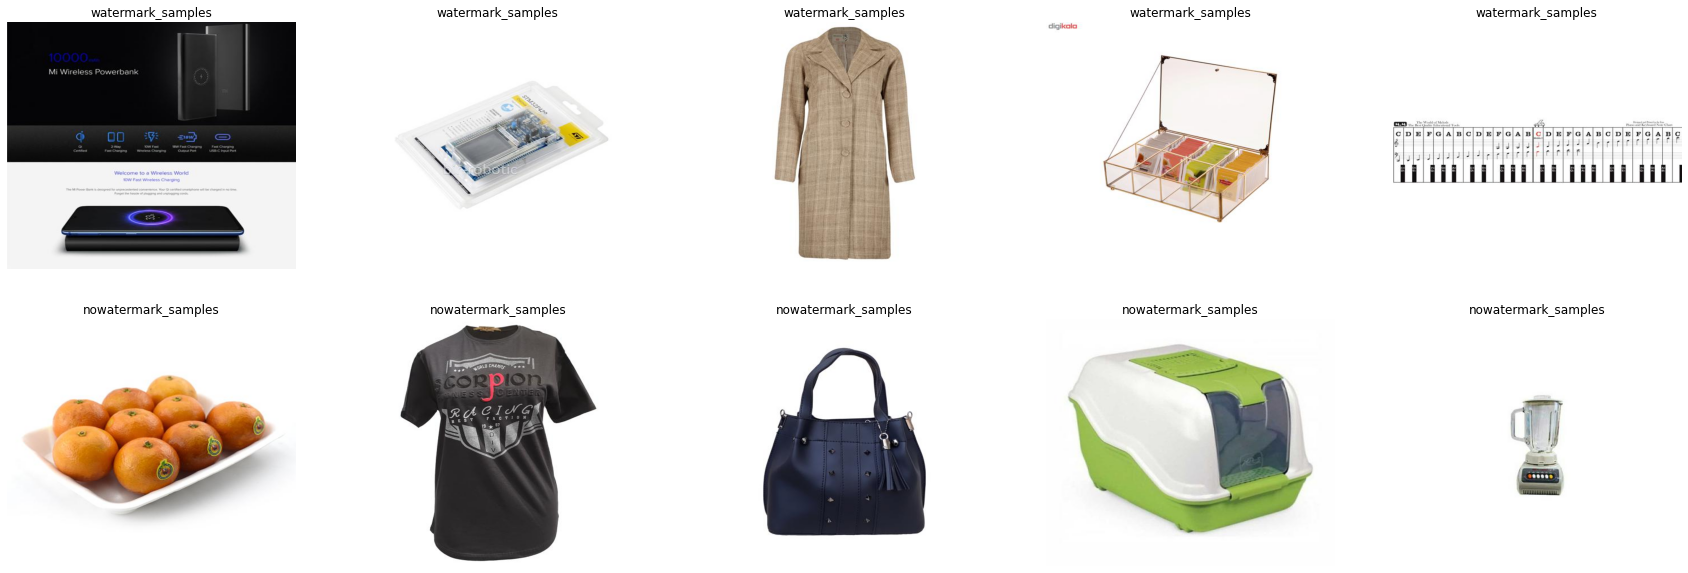

In [9]:
watermark_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
nowatermark_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

samples = watermark_samples + nowatermark_samples
del watermark_samples, nowatermark_samples


f , ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("watermark_samples")
    else:
        ax[i//5, i%5].set_title("nowatermark_samples")
        
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
    
plt.show()    

In [10]:
IMG_SIZE = (224,224)
RANDOM_SEED = 123
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 6801 images belonging to 2 classes.
Found 1781 images belonging to 2 classes.


In [11]:
vgg16_weight_path = 'C:/Users/TAK Rayaneh/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:


model = Sequential()
model.add(base_model)
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='tanh', input_dim=7 * 7 * 512))

model.add(layers.Dense(1, activation='sigmoid'))


model.layers[0].trainable = False


model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
EPOCHS =50
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
) 

history = model.fit(
    train_generator,
    steps_per_epoch=64,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=32,
    #callbacks=[es]
)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
64/64 [==============================] - ETA: 0s - loss: 0.8985 - acc: 0.4738WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000027517D56940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

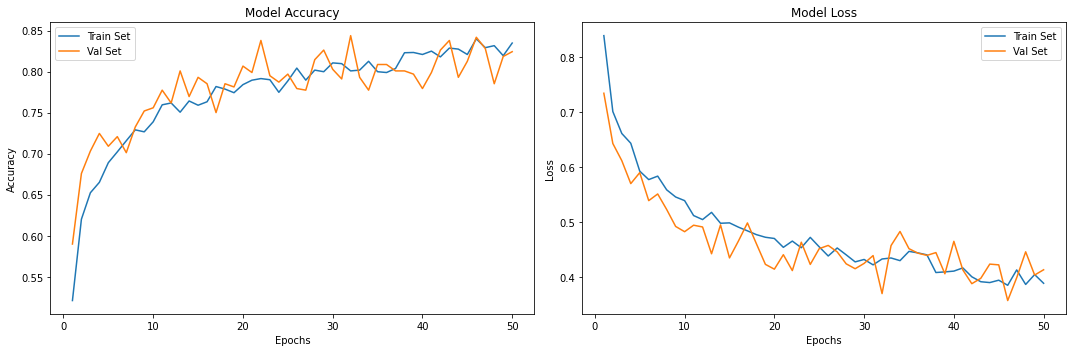

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()
